In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.linalg import eigh
import qutip as qt
import sympy as sym
from joblib import Parallel, delayed, cpu_count

%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})

# Comparison of sqcircuit composite vs full circuit model

In [2]:
fF  = 1e-15
nH  = 1e-9
GHz = 1e9

Csh = 9
C   = 15 
CJ  = 9
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0

Csh_prime = Csh-1
C_prime   = C  +15
CJ_prime  = CJ +3
Lq_prime  = Lq +12
Lr_prime  = Lr +14
Δ_prime   = Δ  +0.1
EJ_prime  = EJ +6

CF, CR = sq_ext.C_CJ_Csh_to_CF_CR_eff(C=C, CJ=CJ, Csh=Csh)
LF, LR = sq_ext.Lq_Lr_to_LF_LR_eff(Lq=Lq, Lr=Lr, Δ=Δ)

CF_prime, CR_prime = sq_ext.C_CJ_Csh_to_CF_CR_eff(C=C_prime, CJ=CJ_prime, Csh=Csh_prime)
LF_prime, LR_prime = sq_ext.Lq_Lr_to_LF_LR_eff(Lq=Lq_prime, Lr=Lr_prime, Δ=Δ_prime)

In [3]:
Δ  = 0.1
LF = 26.5
CF = 26.9
EJ = 5.4
ω_r= 6.46
LR = 140
CR = 1/ (LR* nH)  /(ω_r*2*np.pi*GHz)**2/fF
Lq, Lr = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF, LR=LR, Δ=Δ)
C, Csh, CJ = sq_ext.CF_CR_eff_to_C_CJ_Csh(CF=CF, CR=CR)

Δ_prime = 0.1
LF_prime = 20.4
CF_prime = 22.4
EJ_prime = 9.5
ω_r_prime = 6.274
LR_prime = 100
CR_prime = 1/ (LR_prime* nH)  /(ω_r_prime*2*np.pi*GHz)**2/fF
Lq_prime, Lr_prime = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF_prime, LR=LR_prime, Δ=Δ_prime)
C_prime, Csh_prime, CJ_prime = sq_ext.CF_CR_eff_to_C_CJ_Csh(CF=CF_prime, CR=CR_prime)

In [34]:
nmax_r = 15
nmax_f = 15
CC = 1
only_inner = True
compensate_extra_cap = False
n_eig = 5
φ_ext = 0.5

In [35]:
omega_q_exp = [3.7001944890642844, 3.4505095260121497, 3.0342472605322786]
ω_r_exp = [6.46, 6.274, 5.22] 


In [36]:
H_composite = sq_ext.hamiltonian_qubit_C_qubit(CC=CC, CR=CR, CF=CF, LF=LF, LR=LR, EJ=EJ, Δ=Δ, φ_ext=φ_ext, CR_prime=CR_prime, CF_prime=CF_prime, LF_prime=LF_prime, LR_prime=LR_prime, EJ_prime=EJ_prime, Δ_prime=Δ_prime, φ_ext_prime=φ_ext, nmax_r=nmax_r, nmax_f=nmax_f, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap)
E_composite = sq_ext.diag(H_composite, n_eig,   remove_ground=True)[0]

In [37]:
circ_full = sq_ext.sq_qubit_C_qubit(CC=CC, C=C, CJ=CJ, Csh=Csh, Lq=Lq, Lr=Lr, Δ=Δ, EJ=EJ, φ_ext=φ_ext,
                                      C_prime=C_prime, CJ_prime=CJ_prime, Csh_prime=Csh_prime, Lq_prime=Lq_prime, Lr_prime=Lr_prime, Δ_prime=Δ_prime, EJ_prime=EJ_prime, φ_ext_prime=φ_ext,
                                      nmax_r=nmax_r, nmax_f=nmax_f, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap)
circ_full.diag(n_eig)
E_full = circ_full.efreqs
E_full  = E_full-E_full[0]

In [38]:
E_composite

array([0.000000000000, 3.448459241278, 3.699050305884, 6.273966213364, 6.461457030338])

In [32]:
E_composite

array([0.000000000000, 3.448453705291, 3.699057407756, 6.273966220112, 6.461457038865])

In [39]:
E_full

array([0.000000000000, 3.421674788624, 3.679762115498, 6.075829190799, 6.378563810222])

In [33]:
E_full

array([0.000000000000, 3.421668990319, 3.679762306701, 6.075828361740, 6.378563410394])

In [5]:
φ_ext_values = np.linspace(0.5, 0.75, 50)
# φ_ext_values_full = np.array([0.5, 0.522, 0.55, 0.58, 0.625, 0.67, 0.75])
φ_ext_values_full = np.array([0.5, 0.522, 0.58, 0.67, 0.75])

In [6]:
def comp_spectrum_Q_c_Q_vs_φ_ext(CC, CR, CF, LF, LR, EJ, Δ, φ_ext, CR_prime, CF_prime, LF_prime, LR_prime, EJ_prime, Δ_prime, φ_ext_prime, nmax_r, nmax_f, only_inner, compensate_extra_cap):
    H_composite = sq_ext.hamiltonian_qubit_C_qubit(CC=CC, CR=CR, CF=CF, LF=LF, LR=LR, EJ=EJ, Δ=Δ, φ_ext=φ_ext, 
                                               CR_prime=CR_prime, CF_prime=CF_prime, LF_prime=LF_prime, LR_prime=LR_prime, EJ_prime=EJ_prime, Δ_prime=Δ_prime, φ_ext_prime=φ_ext_prime, 
                                               nmax_r=nmax_r, nmax_f=nmax_f, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap)
    return sq_ext.diag(H_composite, n_eig,   remove_ground=True)[0] 


In [7]:
def full_spectrum_Q_c_Q_vs_φ_ext(CC, C, CJ, Csh, Lq, Lr, Δ, EJ, φ_ext, C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime, φ_ext_prime, nmax_r, nmax_f, only_inner, compensate_extra_cap):
    circ_full = sq_ext.sq_qubit_C_qubit(CC=CC, C=C, CJ=CJ, Csh=Csh, Lq=Lq, Lr=Lr, Δ=Δ, EJ=EJ, φ_ext=φ_ext,
                                          C_prime=C_prime, CJ_prime=CJ_prime, Csh_prime=Csh_prime, Lq_prime=Lq_prime, Lr_prime=Lr_prime, Δ_prime=Δ_prime, EJ_prime=EJ_prime, φ_ext_prime=φ_ext_prime,
                                          nmax_r=nmax_r, nmax_f=nmax_f, only_inner=only_inner, compensate_extra_cap=compensate_extra_cap)
    circ_full.diag(n_eig)
    E = circ_full.efreqs
    return E-E[0]

In [8]:
E_composite = np.array(Parallel(n_jobs=10)( delayed(comp_spectrum_Q_c_Q_vs_φ_ext)(CC, CR, CF, LF, LR, EJ, Δ, φ_ext,
                                                                                  CR_prime, CF_prime, LF_prime, LR_prime, EJ_prime, Δ_prime, φ_ext,
                                                                                  nmax_r, nmax_f, only_inner, compensate_extra_cap) for φ_ext in φ_ext_values))

In [9]:
E_full  = np.array(Parallel(n_jobs=5)( delayed(full_spectrum_Q_c_Q_vs_φ_ext)(CC, C, CJ, Csh, Lq, Lr, Δ, EJ, φ_ext, 
                                                                              C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime, φ_ext,
                                                                              nmax_r, nmax_f, only_inner, compensate_extra_cap) for φ_ext in φ_ext_values_full))

In [10]:
experiment_colors = ['b', 'g', 'r']
experiment_labels = ['Unit cell 1', 'Coupler', 'Unit cell 2']
colors = figs.generate_colors_from_colormap(n_eig, 'tab10')
ω_r_exp = [6.46, 6.274]#, 5.22] 

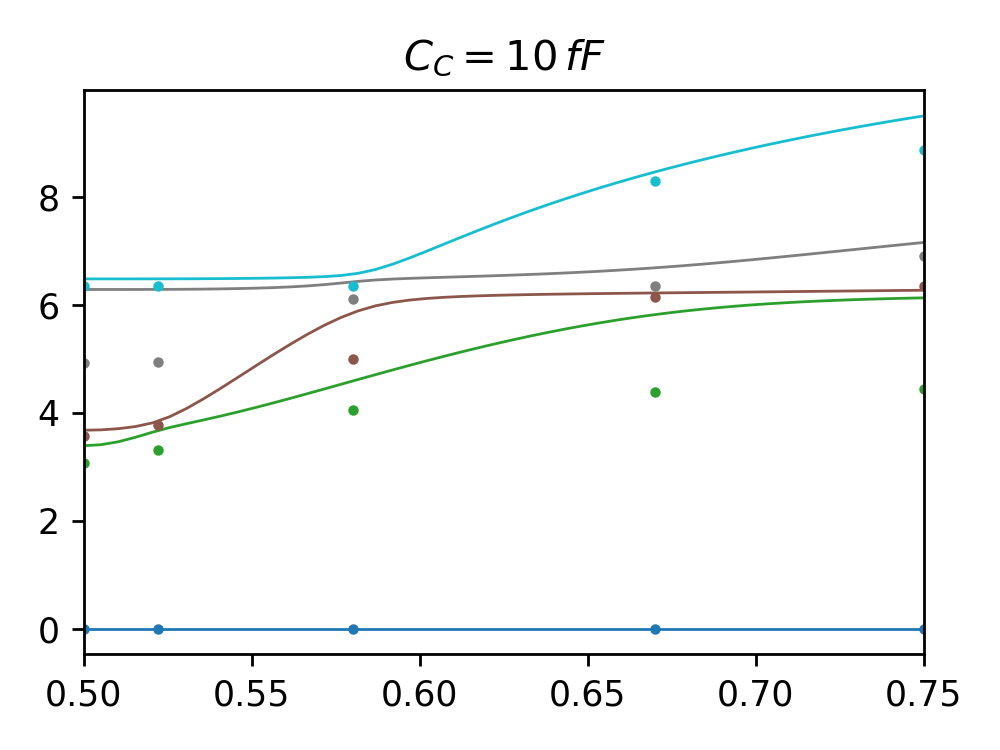

In [11]:
fig, ax = plt.subplots(figsize=[4,3], dpi=250)
[ax.plot(φ_ext_values, E_composite[:,i], linewidth=0.8, color=colors[i]) for i in range(n_eig)]
[ax.plot(φ_ext_values_full, E_full[:,i],'o', color=colors[i], markersize=2) for i in range(n_eig)]
# [ax.hlines(ω_r, φ_ext_values.min(), φ_ext_values.max(), linestyle=':'  , color=experiment_colors[i]) for i, ω_r in enumerate(ω_r_exp) ]
# ax.set_ylim([2.5, 10])
ax.set_xlim([0.5, 0.75])
#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
#ax.set_title(r'$')
ax.set_title(f'$C_C={CC}\\,fF$')
fig.tight_layout()
fig.show()

In [104]:
plt.close('all')

In [197]:
E_composite_vs_CC_φ_ext = []
CC_values = [0, 0.1, 1, 10]
nmax_r = 5
nmax_f = 15
for CC in CC_values:
    E_composite_vs_CC_φ_ext.append( np.array(Parallel(n_jobs=10)( delayed(comp_spectrum_Q_c_Q_vs_φ_ext)(CC, CR, CF, LF, LR, EJ, Δ, φ_ext,
                                                                                  CR_prime, CF_prime, LF_prime, LR_prime, EJ_prime, Δ_prime, φ_ext,
                                                                                  nmax_r, nmax_f, only_inner, compensate_extra_cap) for φ_ext in φ_ext_values)) )

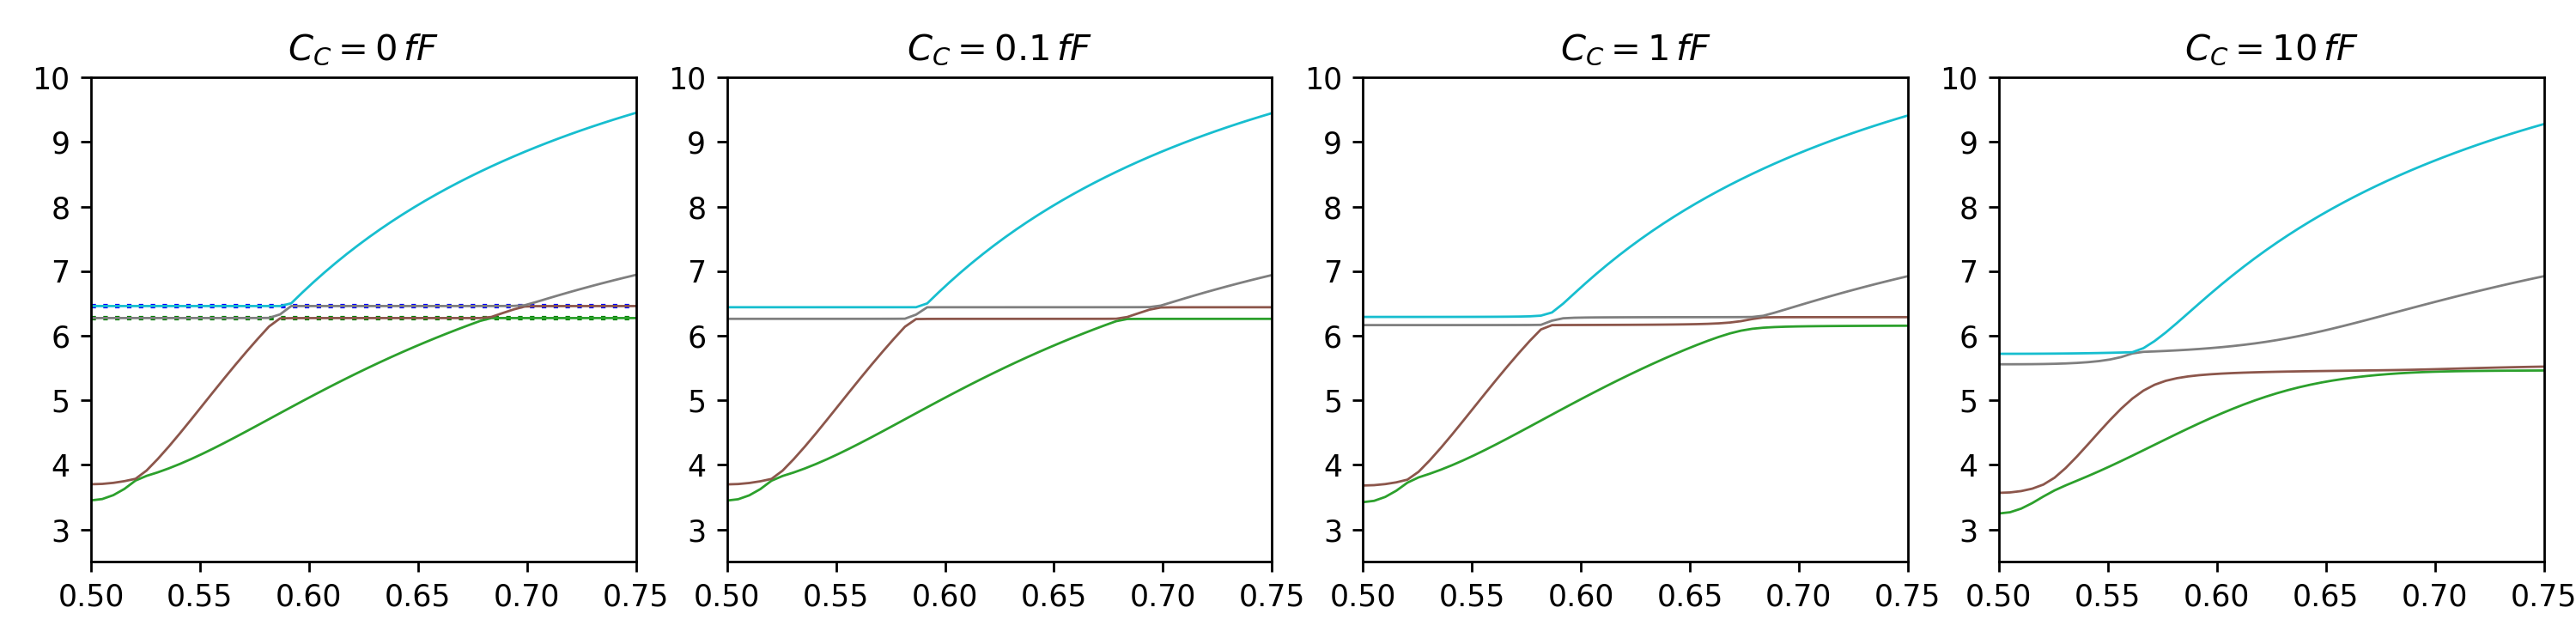

In [199]:
fig, axs = plt.subplots(ncols = len(CC_values), figsize=np.array([3*len(CC_values),3]), dpi=250)

[axs[0].hlines(ω_r, φ_ext_values.min(), φ_ext_values.max(), linestyle=':'  , color=experiment_colors[i]) for i, ω_r in enumerate(ω_r_exp) ]

for ax, CC, E_composite_vs_φ_ext in zip(axs, CC_values, E_composite_vs_CC_φ_ext):
    [ax.plot(φ_ext_values, E_composite_vs_φ_ext[:,i], linewidth=0.8, color=colors[i]) for i in range(n_eig)]
    ax.set_ylim([2.5, 10])
    ax.set_xlim([0.5, 0.75])
    #ax.set_ylabel(r'$')
    #ax.set_xlabel(r'$')
    #ax.set_title(r'$')
    ax.set_title(f'$C_C={CC}\\,fF$')
fig.tight_layout()
fig.show()